# Executive Summary

The analysis focuses on identifying key factors driving customer churn within the dataset and providing actionable insights to improve customer retention. Customer churn, defined as the percentage of customers discontinuing services, is critical to the company’s financial performance. By understanding the drivers of churn, targeted strategies can be implemented to reduce customer attrition and improve satisfaction.

**Dataset Overview**

Total observations: 5,634 customers
Churn rate: 26.6% (1,496 customers)
Imbalanced classes: 73.4% of customers did not churn, while 26.6% churned.

**Key Findings**

Primary Drivers of Churn:

Internet Services:
Customers using Fiber Optic Internet are at the highest risk of churn. This is the most influential factor, indicating potential dissatisfaction with cost or quality.
Customers with No Internet Service are less likely to churn, as they may only be using basic phone or TV services.

Tenure: Customers with shorter tenure are more likely to churn, highlighting the need for better onboarding and early engagement strategies.

Billing and Charges:
High Total Charges and Monthly Charges contribute significantly to churn. Customers may perceive the service as too expensive relative to its value.

Contract Type:
Month-to-month contracts see higher churn rates compared to one- or two-year contracts, emphasizing the importance of long-term agreements.

Service-Specific Insights:

Add-on services such as Online Security, Device Protection, and Tech Support positively impact retention. Customers who do not subscribe to these services are more likely to churn.
Streaming services like Movies and TV are moderately important, suggesting that quality entertainment services help retain customers.

Payment:

Customers paying via Electronic Check show a higher likelihood of churn, potentially due to perceived inconveniences.

**Modeling Insights**

The dataset was analyzed using multiple machine learning models:

Support Vector Machine (SVM): Achieved higher accuracy and recall for churn prediction compared to KNN.

K-Nearest Neighbors (KNN): Performed slightly worse but still identified critical factors for churn.

SVM with a linear kernel was selected as the optimal model for its strong predictive accuracy (81%) and ability to rank feature importance effectively.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('telco_churn.csv')

# Part 1: Data Preparation and Exploration


## 1. Data cleaning

In [2]:
# Replace space with NA
df['TotalCharges'] = df['TotalCharges'].replace(" ", pd.NA)

In [3]:
# Check missing values
missing_values = df.isna().sum()
print(missing_values)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [4]:
# Convert to numeric type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
# Fill missing values with the mean
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

print(df['TotalCharges'].isnull().sum())

0


<ipython-input-5-ae1a9c0b74ef>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [6]:
# Drop irrelevant column
df=df.drop(['customerID'],axis=1)

In [7]:
# Check and report the class balance of the 'Churn' column
class_balance = df['Churn'].value_counts(normalize=True) * 100
print("Class Balance of Churn Column:")
print(class_balance)

Class Balance of Churn Column:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


## 2. Feature Engineering

In [8]:
#Convert binary columns
binary_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0})

#Convert Gender
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})

# Note: Dummies and features scalling are done after creating visualizations

<ipython-input-8-6c48d6e2d0f1>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0})
<ipython-input-8-6c48d6e2d0f1>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})


## 3. Exploratory Data Analysis

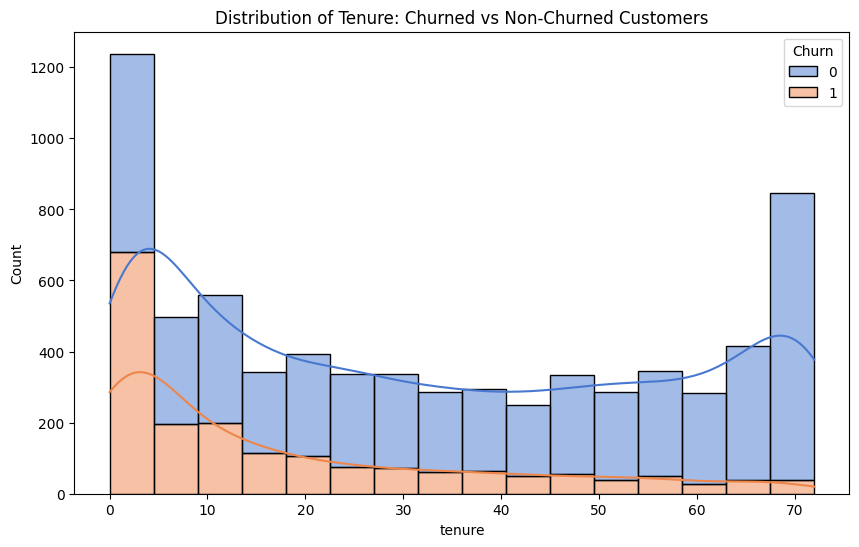

<Figure size 1000x600 with 0 Axes>

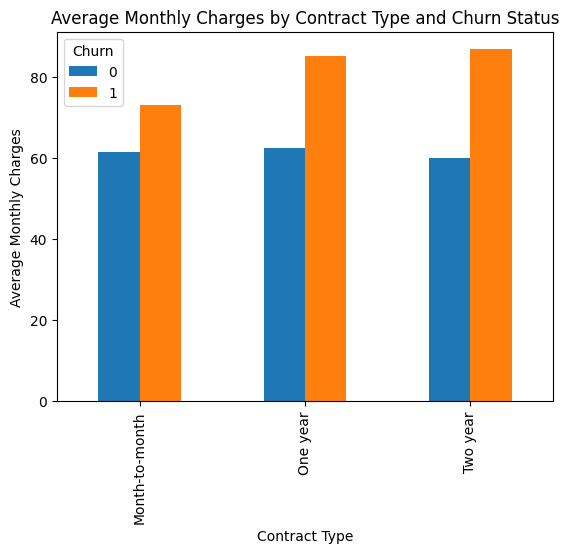

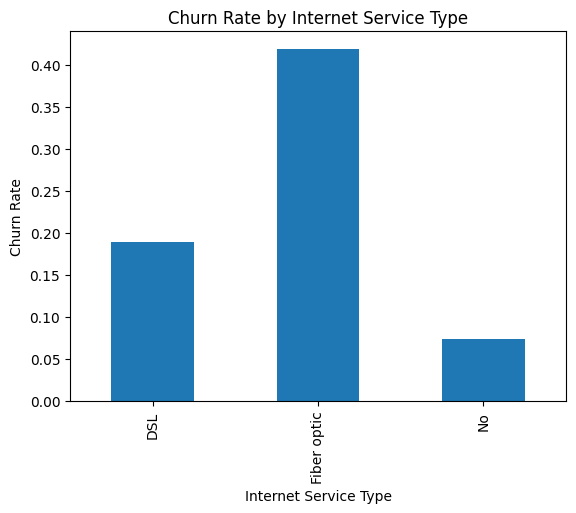

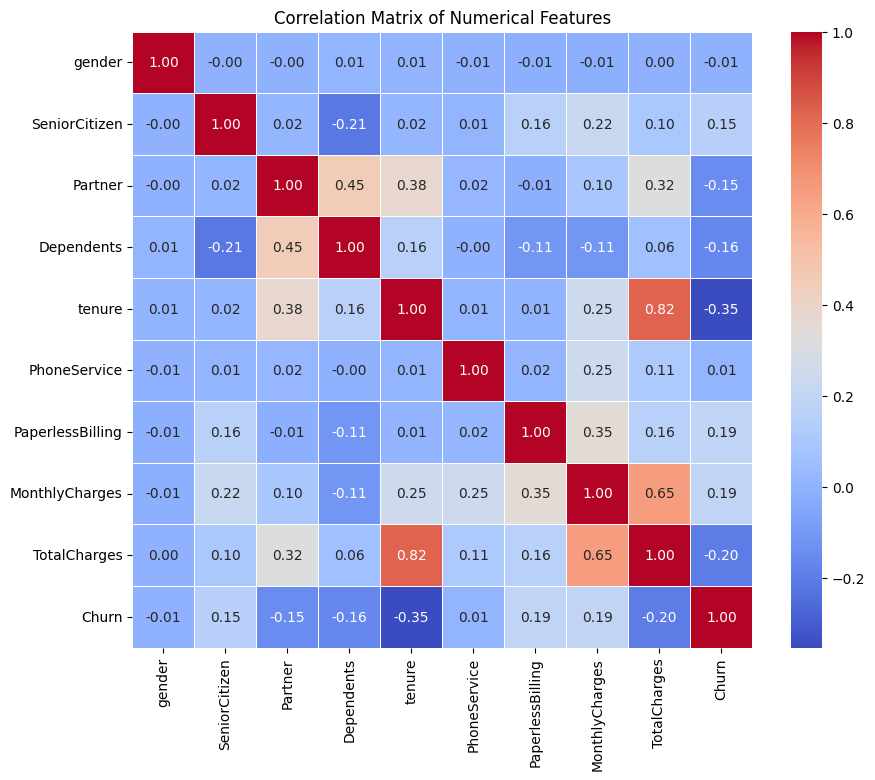

In [9]:
# Create visualizations
# Distribution of tenure for churned vs non-churned customers
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, multiple='stack', palette='muted')
plt.title('Distribution of Tenure: Churned vs Non-Churned Customers')
plt.show()

# Average monthly charges by contract type and churn status
average_charges_by_contract = df.groupby(['Contract', 'Churn'])['MonthlyCharges'].mean().unstack()
plt.figure(figsize=(10, 6))
average_charges_by_contract.plot(kind='bar')
plt.title('Average Monthly Charges by Contract Type and Churn Status')
plt.xlabel('Contract Type')
plt.ylabel('Average Monthly Charges')
plt.show()

# Churn rate by internet service type
churn_rate_by_internet_service = df.groupby('InternetService')['Churn'].mean()
churn_rate_by_internet_service.plot(kind='bar')
plt.title('Churn Rate by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Churn Rate')
plt.show()

# Correlation matrix of numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
# Create dummies for categorical columns
categorical_columns = ['InternetService', 'Contract', 'PaymentMethod', 'MultipleLines']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [12]:
#Scale numerical features
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [13]:
pd.set_option('display.max_columns', None)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,-1.277445,0,No,Yes,No,No,No,No,1,-1.160323,-0.994971,0,False,False,False,False,False,True,False,True,False
1,1,0,0,0,0.066327,1,Yes,No,Yes,No,No,No,0,-0.259629,-0.173876,0,False,False,True,False,False,False,True,False,False
2,1,0,0,0,-1.236724,1,Yes,Yes,No,No,No,No,1,-0.362660,-0.960399,1,False,False,False,False,False,False,True,False,False
3,1,0,0,0,0.514251,0,Yes,No,Yes,Yes,No,No,0,-0.746535,-0.195400,0,False,False,True,False,False,False,False,True,False
4,0,0,0,0,-1.236724,1,No,No,No,No,No,No,1,0.197365,-0.941193,1,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.340876,1,Yes,No,Yes,Yes,Yes,Yes,1,0.665992,-0.129281,0,False,False,True,False,False,False,True,False,True
7039,0,0,1,1,1.613701,1,No,Yes,Yes,No,Yes,Yes,1,1.277533,2.242808,0,True,False,True,False,True,False,False,False,True
7040,0,0,1,1,-0.870241,0,Yes,No,No,No,No,No,1,-1.168632,-0.855182,0,False,False,False,False,False,True,False,True,False
7041,1,1,1,0,-1.155283,1,No,No,No,No,No,No,1,0.320338,-0.872777,1,True,False,False,False,False,False,True,False,True


# Part 2: KNN Model Implementation

## 1. Create a pipeline with StandardScaler and KNeighborsClassifier

In [14]:
binary_mapping = {
    'Yes': 1,
    'No': 0,
    'No internet service': 0  # Treat "No internet service" as equivalent to "No"
}

for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].map(binary_mapping)

In [15]:
pd.set_option('display.max_columns', None)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No phone service,MultipleLines_Yes
0,0,0,1,0,-1.277445,0,0,1,0,0,0,0,1,-1.160323,-0.994971,0,False,False,False,False,False,True,False,True,False
1,1,0,0,0,0.066327,1,1,0,1,0,0,0,0,-0.259629,-0.173876,0,False,False,True,False,False,False,True,False,False
2,1,0,0,0,-1.236724,1,1,1,0,0,0,0,1,-0.362660,-0.960399,1,False,False,False,False,False,False,True,False,False
3,1,0,0,0,0.514251,0,1,0,1,1,0,0,0,-0.746535,-0.195400,0,False,False,True,False,False,False,False,True,False
4,0,0,0,0,-1.236724,1,0,0,0,0,0,0,1,0.197365,-0.941193,1,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,-0.340876,1,1,0,1,1,1,1,1,0.665992,-0.129281,0,False,False,True,False,False,False,True,False,True
7039,0,0,1,1,1.613701,1,0,1,1,0,1,1,1,1.277533,2.242808,0,True,False,True,False,True,False,False,False,True
7040,0,0,1,1,-0.870241,0,1,0,0,0,0,0,1,-1.168632,-0.855182,0,False,False,False,False,False,True,False,True,False
7041,1,1,1,0,-1.155283,1,0,0,0,0,0,0,1,0.320338,-0.872777,1,True,False,False,False,False,False,True,False,True


In [16]:
X = df.drop(columns=['Churn'])  # Features (X)
y = df['Churn']  # Target (y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline with StandardScaler and KNeighborsClassifier
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Feature scaling
    ('knn', KNeighborsClassifier())  # Step 2: KNN classifier
])

# Define the parameter grid for hyperparameter tuning
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # KNN neighbors
    'knn__weights': ['uniform', 'distance']        # Weight function for KNN
}

## 2. Implement GridSearchCV

In [17]:
# Perform GridSearchCV to find the best parameters
grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Output the best parameters found by GridSearchCV
print("Best Parameters:", grid_search_knn.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_knn.best_score_)

Best Parameters: {'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best Cross-Validation Accuracy: 0.7793746581959681


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


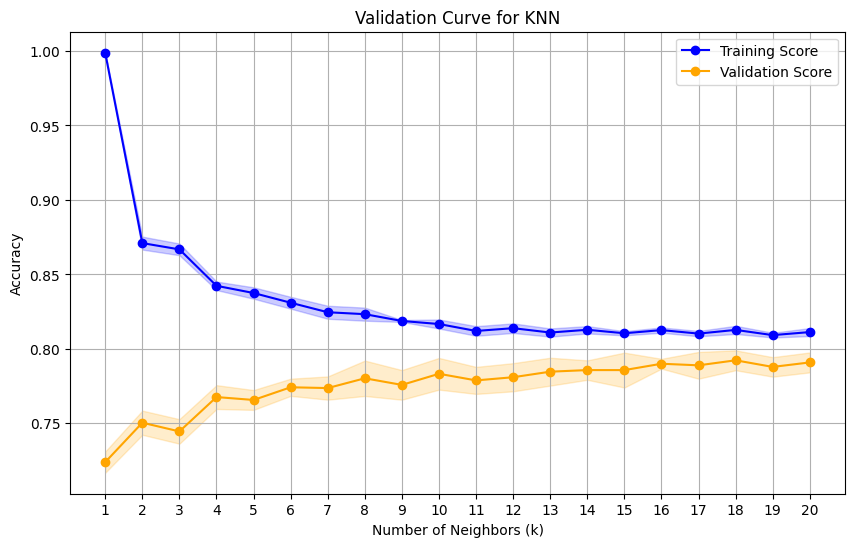

In [18]:
from sklearn.model_selection import validation_curve
# Range of k values to test
k_values = range(1, 21)

# Compute validation curve
train_scores, val_scores = validation_curve(
    KNeighborsClassifier(),        # Model
    X_train,                       # Features
    y_train,                       # Target
    param_name='n_neighbors',      # Hyperparameter to vary
    param_range=k_values,          # Values of the hyperparameter
    cv=5,                          # 5-fold cross-validation
    scoring='accuracy',            # Metric to evaluate
    n_jobs=-1                      # Use all available cores
)

# Compute mean and standard deviation of scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_mean, label="Training Score", color='blue', marker='o')
plt.fill_between(k_values, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(k_values, val_mean, label="Validation Score", color='orange', marker='o')
plt.fill_between(k_values, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

# Add labels, title, and legend
plt.title("Validation Curve for KNN")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend(loc='best')
plt.grid()
plt.show()

## 3. Model Evaluation


Test Set Accuracy: 0.7970191625266146

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.63      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409


Confusion Matrix:
 Predicted    0    1
Actual             
0          917  119
1          167  206


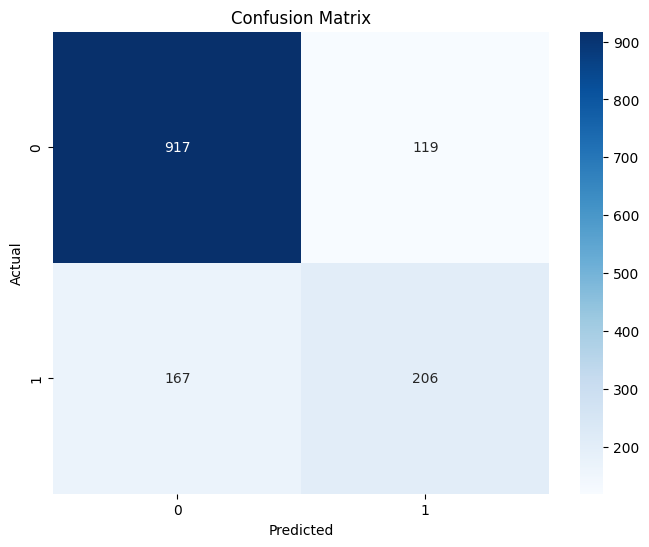

In [19]:
# Evaluate the best model on the test set
y_pred = grid_search_knn.predict(X_test)

# Accuracy and classification report
print("\nTest Set Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:\n", confusion_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.model_selection import cross_val_score
# Scikit-learn Cross-validation
print("\nScikit-learn Cross-validation")
print("-" * 50)

cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3),X, y, cv=5)

print("CV Scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")

# Finding Optimal k using Cross-validation
print("\nFinding Optimal k")
print("-" * 50)

k_values = range(1, 21)
cv_scores_k = []

for k in k_values:
  scores = cross_val_score(KNeighborsClassifier(n_neighbors=k),X, y, cv=5)
  cv_scores_k.append(scores.mean())

optimal_k = k_values[np.argmax(cv_scores_k)]
print(f"Optimal k: {optimal_k}")
print(f"Best CV Score: {max(cv_scores_k):.3f}")




Scikit-learn Cross-validation
--------------------------------------------------
CV Scores: [0.75727466 0.75372605 0.73740241 0.76207386 0.77414773]
Mean CV Accuracy: 0.757
Standard Deviation: 0.012

Finding Optimal k
--------------------------------------------------
Optimal k: 20
Best CV Score: 0.795


In [31]:
# Feature Importance Analysis
print("\nFeature Importance Analysis")
print("-" * 50)

# Train final model with best parameters
best_model = grid_search_knn.best_estimator_
feature_names = X.columns

# Analyze feature importance by removing each feature
feature_scores = []
for i in range(X.shape[1]):
  # Remove one feature
  X_subset = np.delete(X, i, axis=1)
  # Get cross-validation score
  cv_score = cross_val_score(best_model, X_subset, y, cv=5).mean()
  feature_scores.append(cv_score)

feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'CV Score Without Feature': feature_scores,
        'Impact': np.mean(cv_scores) - feature_scores
        })
feature_importance.sort_values('Impact', ascending=False, inplace=True)

print("\nFeature Importance for KNN:")
print(feature_importance)



Feature Importance Analysis
--------------------------------------------------

Feature Importance for KNN:
                                  Feature  CV Score Without Feature    Impact
15            InternetService_Fiber optic                  0.777226 -0.020301
11                        StreamingMovies                  0.777794 -0.020869
4                                  tenure                  0.778646 -0.021721
14                           TotalCharges                  0.779782 -0.022857
23                      MultipleLines_Yes                  0.779924 -0.022999
12                       PaperlessBilling                  0.780066 -0.023141
1                           SeniorCitizen                  0.781627 -0.024702
9                             TechSupport                  0.781769 -0.024844
3                              Dependents                  0.782052 -0.025127
7                            OnlineBackup                  0.782479 -0.025554
17                      Contract_

The two most important features are the ones with the largest negative impact on the cross-validation (CV) score when each feature is removed. Based on the provided data:

OnlineSecurity:

CV Score Without Feature: 0.789863
Impact: -0.032938
Contract_Two year:

CV Score Without Feature: 0.787165
Impact: -0.030240

# Part 3: Support Vector Machine Implementation

## 1. Create a pipeline with StandardScaler and SVC

In [21]:
# Create pipeline with StandardScaler and SVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features
    ('svm', SVC(probability=True))  # SVM classifier with probability estimates
])

# Define parameter grid
param_grid_svm = {
    'svm__C': [0.1, 1, 10, 100],         # Regularization parameter
    'svm__kernel': ['linear', 'rbf'],    # Kernel type: linear or radial basis function
    'svm__gamma': ['scale', 'auto', 0.1, 0.01]  # Kernel coefficient for 'rbf'
}

## 2. Implement GridSearchCV

In [22]:
# Perform GridSearchCV to find the best parameters
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Output the best parameters and accuracy
print("Best Parameters:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_svm.best_score_)

Best Parameters: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.797481012638278


In [54]:
# Test different kernels and C values
kernels = ['linear', 'rbf']
C_values = [0.1, 1, 10, 100]
results = {}

for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C, gamma='scale')
        svm.fit(X_train, y_train)
        train_score = svm.score(X_train, y_train)
        val_score = svm.score(X_test, y_test)
        results[(kernel, C)] = (train_score, val_score)

# Display results in a table format
import pandas as pd
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Training Accuracy', 'Validation Accuracy'])
results_df.index = pd.MultiIndex.from_tuples(results_df.index, names=["Kernel", "C"])
results_df.sort_index(inplace=True)

print("Performance of SVM with Different Kernels and C Values:")
print(results_df)

Performance of SVM with Different Kernels and C Values:
              Training Accuracy  Validation Accuracy
Kernel C                                            
linear 0.1             0.797657             0.820440
       1.0             0.797657             0.821859
       10.0            0.798722             0.821150
       100.0           0.798012             0.819730
rbf    0.1             0.795527             0.808375
       1.0             0.813632             0.814053
       10.0            0.850550             0.801278
       100.0           0.923500             0.759404


Best Overall Model: Based on validation accuracy, the linear kernel at
C=1.0 appears to be the best choice because it provides the highest validation accuracy (82.1%) and doesn't overfit the data. While the RBF kernel shows better training accuracy, its validation accuracy drops at higher C values, indicating that it's overfitting the data.

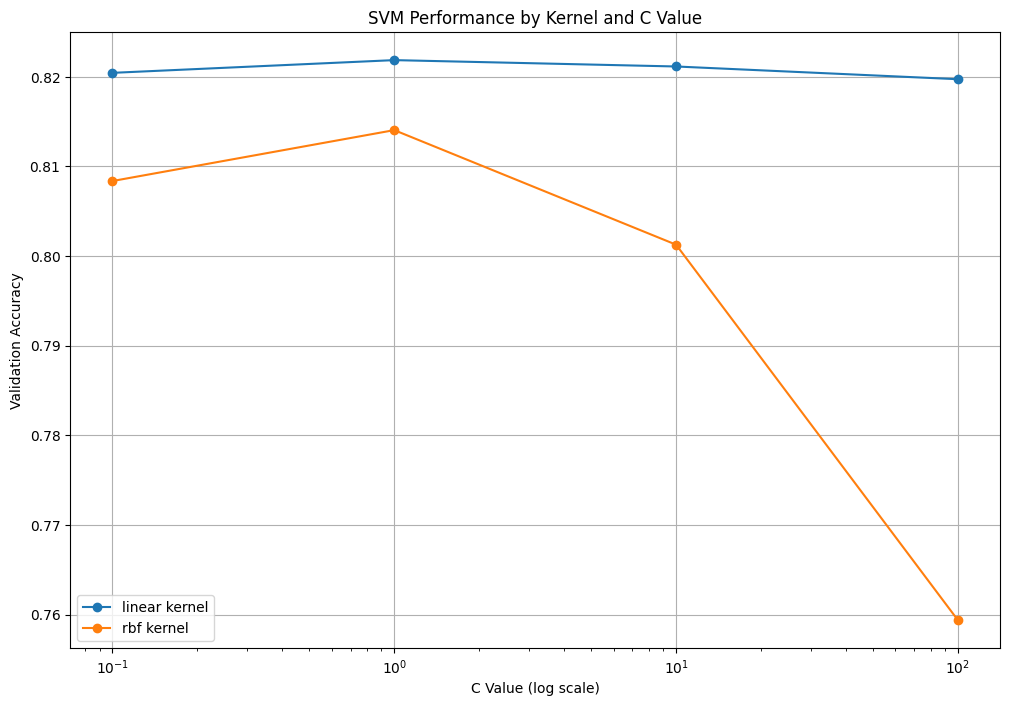

In [41]:
# Visualize the performance
fig, ax = plt.subplots(figsize=(12, 8))

for kernel in kernels:
    kernel_results = results_df.xs(kernel, level='Kernel')
    ax.plot(kernel_results.index, kernel_results['Validation Accuracy'], marker='o', label=f'{kernel} kernel')

ax.set_xscale('log')
ax.set_title("SVM Performance by Kernel and C Value")
ax.set_xlabel("C Value (log scale)")
ax.set_ylabel("Validation Accuracy")
ax.legend()
plt.grid()
plt.show()

## 3. Model Evaluation


Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Confusion Matrix (SVM):
 Predicted    0    1
Actual             
0          942   94
1          171  202


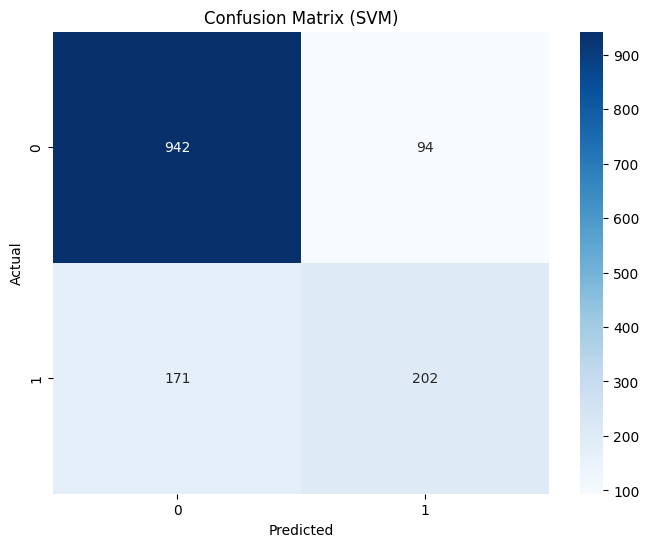

In [24]:
# Classification Report
y_pred_svm = grid_search_svm.predict(X_test)
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))

# Confusion matrix
y_pred_svm = grid_search_svm.predict(X_test)
confusion_matrix_svm = pd.crosstab(y_test, y_pred_svm, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix (SVM):\n", confusion_matrix_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.show()

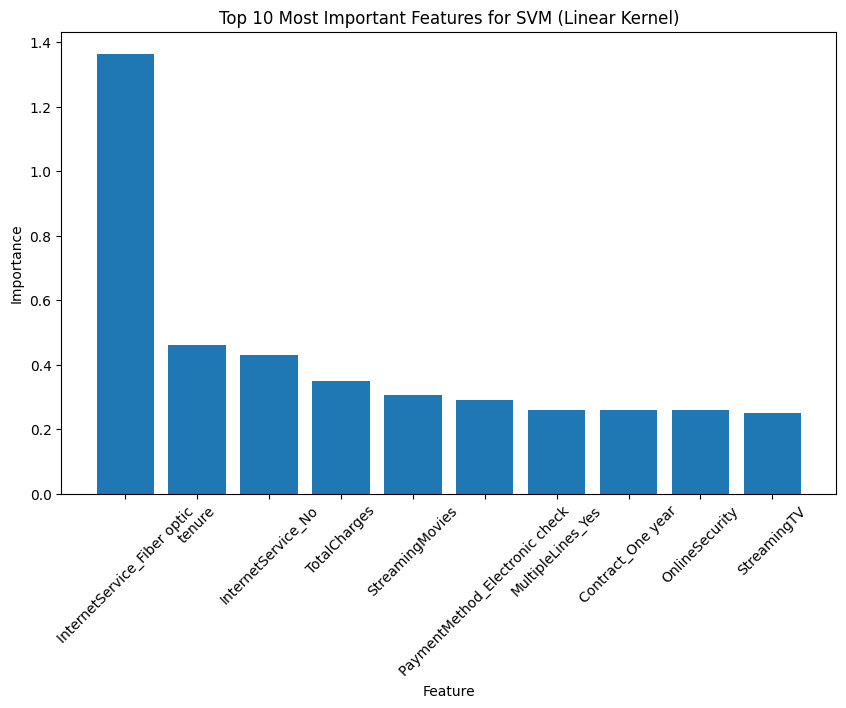

In [30]:
# For the linear kernel, identify the most important features based on coefficients
smv = SVC(kernel='linear', C=1.0)
smv.fit(X_train, y_train)
coefficients = smv.coef_
abs_coefficients = np.abs(coefficients)

feature_importance = np.sum(abs_coefficients, axis=0)
importance_df = pd.DataFrame({ 'Feature': feature_names, 'Importance': feature_importance })
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.title('Top 10 Most Important Features for SVM (Linear Kernel)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

# Part 4: Business Analysis and Recommendations

## Model comparison

**Accuracy**: SVM has a slightly higher overall accuracy than KNN.

Class 0 (Negative class): Both models perform similarly in terms of precision and recall, but SVM has a slight edge in recall for Class 0.

Class 1 (Positive class): SVM has higher precision than KNN, but KNN has slightly better recall.

**F1-Score**: SVM has slightly better performance for both classes, particularly Class 0.

**Confusion Matrix** : SVM has fewer false positives and false negatives for both classes compared to KNN, although KNN does better in correctly identifying the positive class (Class 1).

**Conclusion:**
SVM performs slightly better overall in terms of accuracy, precision, and F1-score, especially for Class 0 (the negative class). KNN, on the other hand, does better at recalling the positive class (Class 1), but it is slightly worse at precision and F1-score for Class 0. Additionally, given the class imbalance in the dataset, SVM with class weights or resampling techniques would be better for deployment. It offers more flexibility in handling imbalanced data and generally provides more robust performance on datasets with higher dimensionality and imbalanced classes.

## Customer Insights

### Key factors that contribute to customer churn
**Internet Services:**

Fiber Optic Internet: This is the most critical factor contributing to churn, as indicated by its high importance score in both SVM and KNN models. Fiber optic services may be associated with higher costs or dissatisfaction.
No Internet Service: Customers without internet service are less likely to churn, as they may only be using basic phone or TV services.

**Tenure:**

Shorter tenure contributes significantly to churn, indicating that newer customers are more likely to leave. Retention efforts should focus on improving the onboarding experience.

**Total Charges and Monthly Charges:**

Higher charges (either total or monthly) are strongly linked to churn. Customers likely perceive these charges as too expensive, leading to dissatisfaction.

**Streaming Services:**

Streaming movies and TV services are moderately important, suggesting that customers who value these services are less likely to churn.

**Payment Method:**

Customers using electronic checks are more likely to churn, potentially indicating dissatisfaction with the billing method.

**Contracts:**

Month-to-month contracts show higher churn rates compared to one-year or two-year contracts, as customers with flexible agreements are more likely to switch providers.

**Add-on Services:**

OnlineSecurity, DeviceProtection, TechSupport: Customers who lack these services are more likely to churn, indicating these add-ons may increase customer satisfaction and perceived value.



### Services that have the highest impact on churn

**Internet Services:**

Fiber Optic Internet stands out as the most significant factor. Addressing issues related to fiber optic service (e.g., cost, reliability, or perceived value) could drastically reduce churn.
Customers with No Internet Service tend to have lower churn, likely because they rely on fewer services.

**Security Services:**

Add-ons like OnlineSecurity and DeviceProtection have a noticeable impact. Customers without these services may feel underserved and are more likely to churn.

**Streaming Services:**

StreamingMovies and StreamingTV show moderate importance, indicating that providing quality entertainment services can improve retention.
Phone Service:

This factor has relatively less importance compared to internet and security services. However, customers without multiple lines may perceive less value and be at risk of churn.


## Business Recommendations


**1. Focus on Fiber Optic Users:**

Analyze customer feedback to identify issues with fiber optic service.
Offer promotional discounts or bundled services to improve satisfaction.

**2. Enhance Add-on Services:**

Upsell security services like OnlineSecurity and DeviceProtection.
Bundle these services with other offerings to increase retention.

**2. Target High-Charge Customers:**

Create pricing plans or offer loyalty discounts for customers with high monthly or total charges.

**3. Promote Long-Term Contracts:**

Encourage customers on month-to-month contracts to switch to longer-term plans by providing incentives.

**4. Improve Retention Among New Customers:**

Develop strategies to improve the onboarding experience and engagement for customers with shorter tenure.